# MRI PET 分别跑ECAresnet 结果融合

In [1]:
#只有MRI可以跑通
import os 
os.environ['CUDA_VISIBLE_DEVICES'] = "1" 
import time
# import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
# from torchvision import datasets
from torchvision import transforms
from torch.utils.data import DataLoader
from PIL import Image
import pickle as p
import hiddenlayer as hl
from ECAresnet import *


if torch.cuda.is_available():
    print("cuda is available")
    torch.backends.cudnn.deterministic = True

# Device
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Device:', DEVICE)


cuda is available
Device: cuda:0


In [2]:
class MyDataset(torch.utils.data.Dataset):
    def __init__(self, root):
        super(MyDataset, self).__init__()
        MRI_PET_match_all = p.load(open(root,"rb"),encoding='iso-8859-1')
        MRI = []
        PET = []
        group = []
        for index,row in MRI_PET_match_all.iterrows():
            MRI.append(row['MRI_img_array'])
            PET.append(row['PET_img_array'])
            group.append(row['Group'])
        self.MRI = MRI
        self.PET = PET
        self.group = group  

    def __getitem__(self, index):
        mri = torch.from_numpy(self.MRI[index].transpose(2,1,0)).float()
        pet = torch.from_numpy(self.MRI[index].transpose(2,1,0)).float()
        group = self.group[index]
        
        return mri,pet,group

    def __len__(self):
        return len(self.MRI)

train_data = MyDataset("/home/gc/gechang/gec_multi_fusion/end_to_end/train.pkl")
test_data = MyDataset("/home/gc/gechang/gec_multi_fusion/end_to_end/test.pkl")

train_loader = DataLoader(train_data, batch_size = 2, num_workers = 8, shuffle=True)
test_loader = DataLoader(test_data, batch_size = 2, num_workers = 8)

In [3]:
class ECAfusionModel(nn.Module):
    def __init__(self):
        super(ECAfusionModel,self).__init__()
      
        self.ECAres_MRI = ECA_ResNet18()
        self.ECAres_PET = ECA_ResNet18()
        self.fc_comb = nn.Sequential(
            nn.Linear(6,3)
        )
        
        
    #定义网络的前向传播
    def forward(self,MRI,PET):
        MRI = self.ECAres_MRI(MRI)
        PET = self.ECAres_PET(PET)
        concat = torch.cat((MRI, PET), 1)
        output = self.fc_comb(concat)
        return output

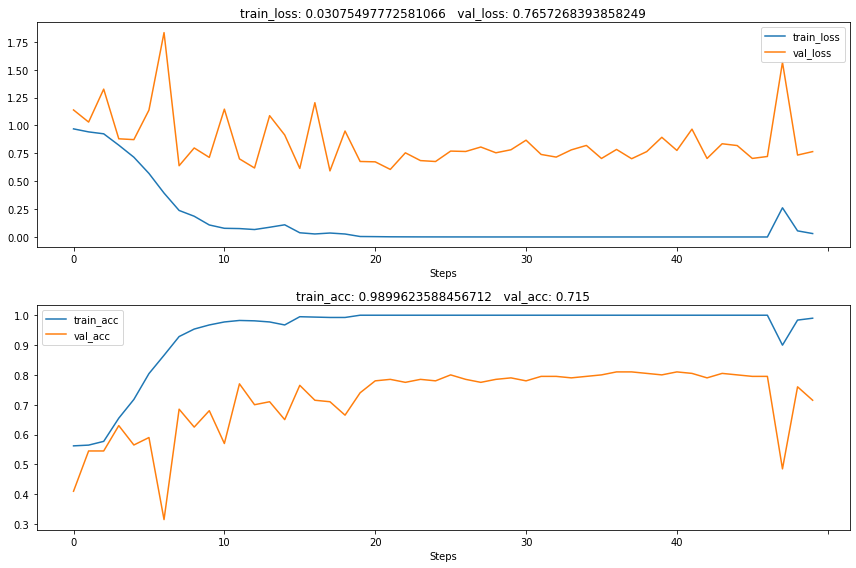

In [4]:
model = ECAfusionModel()
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)


#记录训练过程指标
historyl = hl.History()
#使用Canves进行可视化
canvasl = hl.Canvas()


#对模型进行迭代训练，对所有的数据训练epoch轮
for epoch in range(50):
    train_loss_epoch = 0
    val_loss_epoch = 0
    train_corrects = 0
    val_corrects = 0
    #对训练数据的加载器进行迭代计算
    model.train().cuda()
    for step,(mri,pet,group) in enumerate(train_loader):
        ##计算每个batch的损失
        mri = mri.to(DEVICE)
        pet = pet.to(DEVICE)
        group = group.to(DEVICE)
        output = model(mri,pet)
        loss = criterion(output,group)#交叉熵损失函数
        pre_lab = torch.argmax(output,1)
        optimizer.zero_grad()#每个迭代步的梯度初始化为0
        loss.backward()#损失的后向传播，计算梯度
        optimizer.step()#使用梯度进行优化
        train_loss_epoch += loss.item()*group.size(0)
        train_corrects += torch.sum(pre_lab == group.to(DEVICE).data)
    #计算一个epoch的损失和精度
    train_loss = train_loss_epoch/len(train_data.group)
    train_acc = train_corrects.double()/len(train_data.group)
    print("epoch:",epoch,"train_loss:",train_loss,"train_acc:",train_acc)
     #计算在验证集上的表现
    model.eval()
    for step,(mri,pet,group) in enumerate(test_loader):
        mri = mri.to(DEVICE)
        pet = pet.to(DEVICE)
        group = group.to(DEVICE)
        output = model(mri,pet)
        loss = criterion(output,group.to(DEVICE))
        pre_lab = torch.argmax(output,1).to(DEVICE)
        val_loss_epoch += loss.item()*group.size(0)
        val_corrects += torch.sum(pre_lab == group.to(DEVICE).data)

    #计算一个epoch上的输出loss和acc
    val_loss = val_loss_epoch/len(test_data.group)
    val_acc = val_corrects.double()/len(test_data.group)
    print("epoch:",epoch,"val_loss:",val_loss,"val_acc:",val_acc)
    # #保存每个epoch上的输出loss和acc
    historyl.log(epoch,train_loss=train_loss,val_loss = val_loss,train_acc = train_acc.item(),val_acc = val_acc.item())
    # #可视化网络训练的过程
    with canvasl:
        canvasl.draw_plot([historyl["train_loss"],historyl["val_loss"]])
        canvasl.draw_plot([historyl["train_acc"],historyl["val_acc"]])
